(tflite_p38) pip3 install tensorflow

In [1]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [3]:
# Create list of all targets (minus background noise)
dataset_path = "D:\\vsc_ws_voice_learning\\tflite-speech-recognition\\speech_commands_dataset"
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [4]:
# Settings
feature_sets_path = 'D:\\vsc_ws_voice_learning\\tflite-speech-recognition\\feature_sets_directory'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'wake_word_stop_model.h5'
wake_word = 'stop'

In [5]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [6]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [7]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77488, 16, 16)
(9724, 16, 16)
(9644, 16, 16)


In [8]:
# Peek at labels
print(y_val)

[10. 27. 11. ...  3. 23. 33.]


In [9]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
wake_word_index = all_targets.index(wake_word)
y_train = np.equal(y_train, wake_word_index).astype('float64')
y_val = np.equal(y_val, wake_word_index).astype('float64')
y_test = np.equal(y_test, wake_word_index).astype('float64')

In [10]:
# Peek at labels after conversion
print(y_val)

[0. 0. 0. ... 0. 0. 0.]


In [11]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

0.036404771698889345
0.9635952283011107


In [12]:
# View the dimensions of our input data
print(x_train.shape)

(77488, 16, 16)


In [13]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(77488, 16, 16, 1)
(9724, 16, 16, 1)
(9644, 16, 16, 1)


In [14]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [15]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [16]:
# Display model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 7, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 64)         0

In [17]:
# Add training parameters to model
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])

In [18]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
775/775 [==============================] - 5s 6ms/step - loss: 0.1173 - acc: 0.9653 - val_loss: 0.0903 - val_acc: 0.9708
Epoch 2/30
775/775 [==============================] - 5s 7ms/step - loss: 0.0771 - acc: 0.9761 - val_loss: 0.0579 - val_acc: 0.9823
Epoch 3/30
775/775 [==============================] - 5s 7ms/step - loss: 0.0659 - acc: 0.9798 - val_loss: 0.0531 - val_acc: 0.9840
Epoch 4/30
775/775 [==============================] - 5s 7ms/step - loss: 0.0603 - acc: 0.9817 - val_loss: 0.0531 - val_acc: 0.9831
Epoch 5/30
775/775 [==============================] - 5s 7ms/step - loss: 0.0576 - acc: 0.9825 - val_loss: 0.0567 - val_acc: 0.9840
Epoch 6/30
775/775 [==============================] - 5s 7ms/step - loss: 0.0564 - acc: 0.9835 - val_loss: 0.0638 - val_acc: 0.9816
Epoch 7/30
775/775 [==============================] - 5s 7ms/step - loss: 0.0585 - acc: 0.9834 - val_loss: 0.0505 - val_acc: 0.9864
Epoch 8/30
775/775 [==============================] - 5s 7ms/step - loss: 0.

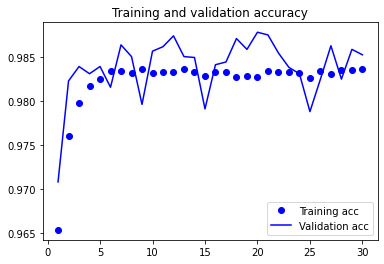

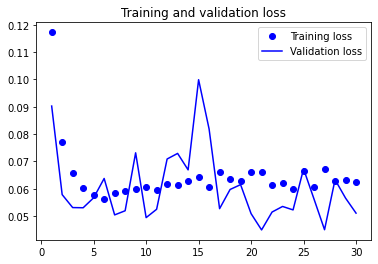

In [19]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
# Save the model as a file
models.save_model(model, model_filename)

In [21]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

53
59
80
103
105
114
135
141
154
161
169
229
256
260
263
273
290
336
340
384
388
417
476
487
519
532
561
574
620
667
685
698
718
724
768
801
842
868
936
956
1028
1070
1075
1131
1132
1145
1175
1191
1202
1222
1224
1229
1263
1280
1283
1297
1322
1353
1402
1418
1424
1441
1448
1450
1472
1508
1523
1533
1576
1592
1609
1611
1652
1684
1703
1704
1706
1731
1752
1775
1791
1815
1839
1850
1907
1950
1964
2028
2036
2049
2077
2134
2148
2149
2195
2228
2246
2314
2354
2379
2397
2412
2486
2494
2508
2517
2520
2527
2553
2586
2636
2658
2663
2707
2738
2751
2787
2802
2805
2848
2856
2867
2869
2880
2933
2948
2949
2951
2971
2992
3027
3066
3124
3158
3159
3174
3191
3204
3211
3217
3233
3251
3271
3288
3335
3353
3395
3418
3434
3464
3465
3468
3474
3520
3576
3601
3615
3738
3815
3816
3886
3938
3977
3981
4031
4082
4158
4175
4198
4245
4259
4309
4342
4346
4351
4414
4425
4444
4492
4516
4544
4554
4570
4601
4673
4756
4761
4797
4815
4817
4905
4908
4952
4996
5012
5035
5107
5113
5231
5254
5278
5292
5315
5360
5370
5372
5416
5421
542

In [22]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(100, 110):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

Answer: 0.0  Prediction: [[4.9250375e-11]]
Answer: 0.0  Prediction: [[6.4256665e-07]]
Answer: 0.0  Prediction: [[0.00884172]]
Answer: 1.0  Prediction: [[0.04275051]]
Answer: 0.0  Prediction: [[3.8332887e-06]]
Answer: 1.0  Prediction: [[0.00014016]]
Answer: 0.0  Prediction: [[0.0020695]]
Answer: 0.0  Prediction: [[0.]]
Answer: 0.0  Prediction: [[2.7101161e-05]]
Answer: 0.0  Prediction: [[2.3290049e-07]]


In [23]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

302/302 [==============================] - 0s 1ms/step - loss: 0.0788 - acc: 0.9822


[0.0788053572177887, 0.9821650981903076]